## Beam Wander - Mulit-Regression Model

Explore the longterm behaviour of the beam wander for RV with a linear model

## Imports

In [2]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

from functions.reduce import __reduce
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan


In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'

## Configurations

In [4]:
config = {}

config['ring'] = "V"

config['modeldata'] = "df4"

config['file'] = f"multi_regression_R{config['ring']}_{config['modeldata']}.pkl"

config['path_to_figs'] = data_path+"manuscripts/manuscript_romy_drifts/figures/"

config['path_to_data'] = data_path+"manuscripts/manuscript_romy_drifts/data/"


## Methods

In [5]:
def __makeplot_corr_matrix(ddf, target, m="pearson"):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    _df = ddf.copy()

    if "time" in list(_df.columns):
        _df.drop(columns="time", inplace=True)

    _df = _df.iloc[:, :]

    corr = _df.corr(method=m)

    # mask upper triangle
    corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)

    print(corr)

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
    cmap = plt.get_cmap("coolwarm", 9)

    # Generate a mask for the upper triangle
    # mask = np.zeros_like(corr, dtype=bool)
    # mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    # sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

    im = plt.pcolor(corr, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

    plt.colorbar(im, extend="both")

    labels = list(corr.columns)
    ax = plt.gca()
    ax.set_xticks(np.arange(len(labels))+0.5)
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(len(labels))+0.5)
    ax.set_yticklabels(labels)


    fig.suptitle(f'{m} correlation matrix', fontsize=15)

    fig.tight_layout();

    return fig

In [6]:
def __find_model(ddf, _features, target="fj_fs", reg="theilsen"):

    from sklearn import linear_model
    from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

    _df = ddf.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    print(_features)

    # define x data
    X = _df[_features].values.reshape(-1, len(_features))

    # define y data
    y = _df[target].values

    # multi linear regression

    # using OLS
    if reg.lower() == "ols":
        ols = linear_model.LinearRegression()
        model = ols.fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    elif reg.lower() == "ransac":
        model = RANSACRegressor(random_state=1).fit(X, y)
        print("R2:", model.score(X, y))
        print("IC: ", model.estimator_.intercept_)
        print("Coef: ",  model.estimator_.coef_)
        for _f, _c in zip(_features, model.estimator_.coef_):
            print(f"{_f} : {_c}")

    # using TheilSen
    elif reg.lower() == "theilsen":
        model = TheilSenRegressor().fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(model.predict(x_pred))

    out = {}
    out['model'] = model
    out['r2'] = model.score(X, y)
    out['tp'] = _df.time
    out['dp'] = model_predict

    # plt.plot(_df.time, model_predict)
    # plt.plot(_df.time, _df[target].values)

    return out

In [7]:
def __predict_data(df_in, _features, _model, target="fj_fs"):

    from numpy import array

    _df = df_in.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(_model.predict(x_pred))

    return array(_df.time), array(model_predict)

In [8]:
def __makeplot0(_df):

    import matplotlib.pyplot as plt

    blocked = ["time", "fj_fs", "fj_bs_dj"]
    keys = [k for k in _df.keys() if k not in blocked ]

    Nrow, Ncol = len(keys), 1

    tscale = 1/86400

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=True)

    plt.subplots_adjust(hspace=0.05)

    for i, k in enumerate(keys):

        ax[i-1].plot(_df.time*tscale, _df[k]/np.nanpercentile(abs(_df[k]), 99), label=k)

    for i in range(Nrow):
        # ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[i].set_ylim(-1.3, 1.3)
        ax[i].legend(loc=1)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

    ax[Nrow-1].set_xlabel(f"Time (days)", fontsize=font)

    plt.show();
    return fig

### Read Dataframe

In [9]:
df = read_pickle(config['path_to_data']+config['file'])

In [10]:
NN = 60
for k in df.keys():
    if k != "time":
        df[k] = __interpolate_nan(__smooth(df[k], NN, setpad=True))

### Define features

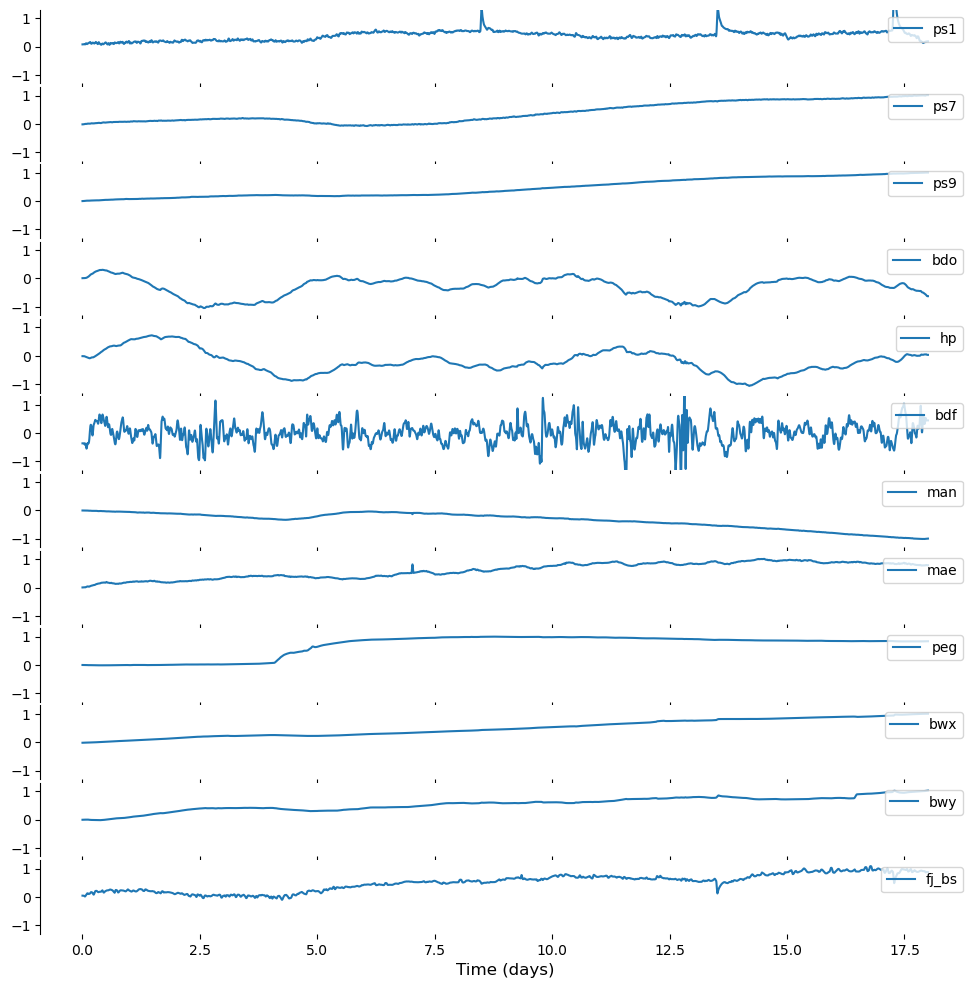

In [11]:
fig = __makeplot0(df);

fig.savefig(config['path_to_figs']+f"SF_R{config['ring']}_{config['modeldata']}_data.png",
            format="png", dpi=150, bbox_inches='tight')


In [17]:
features = ['time', 'bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']

df1 = df[features]

# get size of frame
N = df1.shape[0]

# split frame in two parts
df1_part1 = df1.iloc[:int(N*2/3)]
df1_part2 = df1.iloc[int(N*2/3):]

In [18]:
# set feature to model
target1 = "bwy"

# features1 = ['bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']
features1 = ['bwy', 'bdo', 'ps1', 'ps7', 'ps9', 'mae', 'man']

# find model with first part of frame
out_y = __find_model(df1_part1, features1, target=target1, reg="ransac")

# predict data for second part of frame
t_predict_y, d_predict_y = __predict_data(df1_part2, features1, out_y['model'], target=target1)


['bdo', 'ps1', 'ps7', 'ps9', 'mae', 'man']
R2: 0.9874377321345491
IC:  -4.056395615802451
Coef:  [-2.62770777e+00  2.36456527e+02 -3.81682309e+01  8.03309383e+01
  2.50325850e+07  4.40632919e+06]
bdo : -2.6277077655251997
ps1 : 236.45652689141195
ps7 : -38.16823087821959
ps9 : 80.33093825629433
mae : 25032585.014413998
man : 4406329.189253739


In [19]:
# set feature to model
target2 = "bwx"

# features2 = ['bwx', 'bdo', 'hp',  'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']
features2 = ['bwx', 'ps7', 'ps9', 'mae', 'man', 'peg']

# find model with first part of frame
out_x = __find_model(df1_part1, features2, target=target2, reg="ransac")

# predict data for second part of frame
t_predict_x, d_predict_x = __predict_data(df1_part2, features2, out_x['model'], target=target2)


['ps7', 'ps9', 'mae', 'man', 'peg']
R2: 0.9853321872635293
IC:  -0.002152290415341873
Coef:  [-3.90566186e-02  1.33405025e-01  1.77406161e+04 -3.61204111e+02
  2.43829335e-03]
ps7 : -0.03905661862767201
ps9 : 0.13340502505704305
mae : 17740.616067779963
man : -361.2041114212583
peg : 0.0024382933492153452


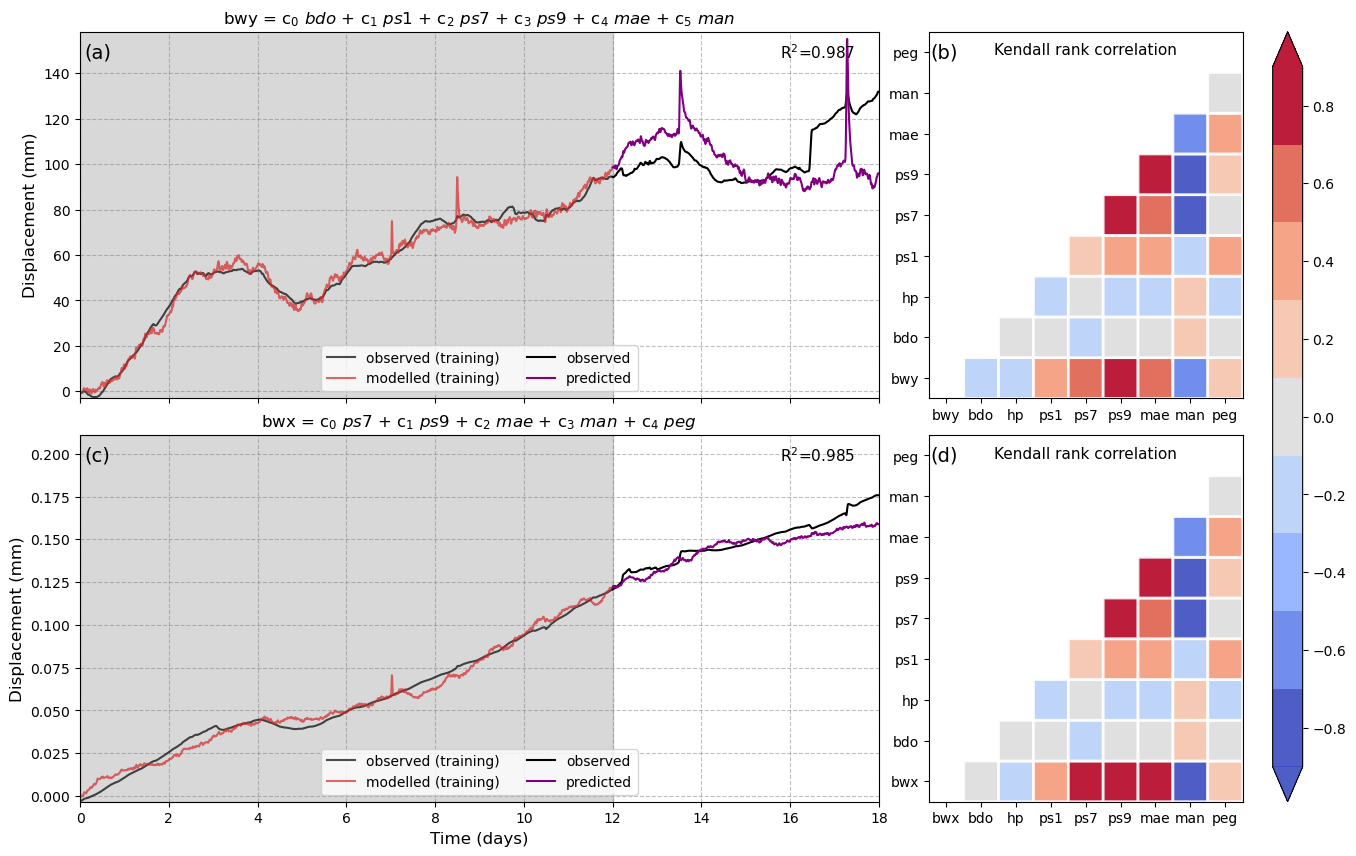

In [22]:
def __makeplot3(df0, df1, df2,
                tp1, dp1, model1, target1,
                tp2, dp2, model2, target2
               ):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    def __corr(df_in, m="kendall", targetx="not_the_one"):

        _df = df_in.copy()

        if "time" in list(_df.columns):
            _df.drop(columns="time", inplace=True)
            _df.drop(columns=targetx, inplace=True)

        _df = _df.iloc[:, :]

        corr = _df.corr(method=m.lower())

        # mask upper triangle
        corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)

        return corr

    c_method = "Kendall" # kendall pearson spearman

    corr1 = __corr(df0, m=c_method, targetx=target2)

    corr2 = __corr(df0, m=c_method, targetx=target1)

    # _________________________________________

    tscale = 1/86400

    Nrow, Ncol = 2, 10

    cmap = plt.get_cmap("coolwarm", 9)

    fig = plt.figure(figsize=(15, 10))

    font = 12

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1, wspace=0.7)

    ax0 = fig.add_subplot(gs[0, :7])
    ax1 = fig.add_subplot(gs[0, 7:])
    ax2 = fig.add_subplot(gs[1, :7])
    ax3 = fig.add_subplot(gs[1, 7:])

    axes = [ax0, ax1, ax2, ax3]

    ax0.plot(df1.time*tscale, df1[target1], color="k", label="observed (training)", alpha=0.7)
    ax0.plot(model1['tp']*tscale, model1['dp'], color="tab:red", label="modelled (training)", alpha=0.7)

    ax0.fill_betweenx([-1000, 1000], df1.time.min()*tscale, df1.time.max()*tscale, color="grey", alpha=0.3)

    ax0.plot(df2.time*tscale, df2[target1], color="k", label="observed")
    ax0.plot(tp1*tscale, dp1, color="purple", label="predicted")

    ax0.set_xticklabels([])

    im1 = ax1.pcolor(corr1, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

    # add colorbar
    cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax, extend="both")

    labels = list(corr1.columns)
    ax1.set_xticks(np.arange(len(labels))+0.5)
    ax1.set_xticklabels(labels)
    ax1.set_yticks(np.arange(len(labels))+0.5)
    ax1.set_yticklabels(labels)

    ax1.text(0.5, 0.97, f"{c_method} rank correlation", ha="center", va="top", transform=ax1.transAxes, fontsize=font-1)

    ax2.plot(df1.time*tscale, df1[target2], color="k", label="observed (training)", alpha=0.7)
    ax2.plot(model2['tp']*tscale, model2['dp'], color="tab:red", label="modelled (training)", alpha=0.7)

    ax2.fill_betweenx([df0[target2].min()*1.2, df0[target2].max()*1.2], df1.time.min()*tscale, df1.time.max()*tscale, color="grey", alpha=0.3)

    ax2.plot(df2.time*tscale, df2[target2], color="k", label="observed")
    ax2.plot(tp2*tscale, dp2, color="purple", label="predicted")

    im2 = ax3.pcolor(corr2, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)
    # plt.colorbar(im2, extend="both")

    labels = list(corr2.columns)
    # ax3.yaxis.set_label_position("right")
    # ax3.yaxis.tick_right()
    ax3.set_xticks(np.arange(len(labels))+0.5)
    ax3.set_xticklabels(labels)
    ax3.set_yticks(np.arange(len(labels))+0.5)
    ax3.set_yticklabels(labels)

    ax3.text(0.5, 0.97, f"{c_method} rank correlation", ha="center", va="top", transform=ax3.transAxes, fontsize=font-1)

    for ax in [ax0, ax2]:

        ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax.legend(loc=8, fontsize=font-2, ncol=2)
        ax.set_ylabel(f"Displacement (mm)", fontsize=font)

    ax0.text(0.97, 0.97, f"R$^2$={model1['r2']:.3f}", ha="right", va="top", transform=ax0.transAxes, fontsize=font-1)
    ax2.text(0.97, 0.97, f"R$^2$={model2['r2']:.3f}", ha="right", va="top", transform=ax2.transAxes, fontsize=font-1)

    ax0.set_xlim(0, df2.time.max()*tscale)
    ax2.set_xlim(0, df2.time.max()*tscale)

    # ax0.set_ylim(-0.01, 0.055)
    # ax2.set_ylim(-0.002, 0.005)

    ax0.set_ylim(df0[target1].min()*1.2, df0[target1].max()*1.2)
    ax2.set_ylim(df0[target2].min()*1.2, df0[target2].max()*1.2)

    mod = ""
    for i, ll in enumerate(features1):
        mod += f"c$_{i}$ ${ll}$ + "

    tit1 = f"{target1} = {mod}"
    ax0.set_title(tit1[:-2])

    mod = ""
    for i, ll in enumerate(features2):
        mod += f"c$_{i}$ ${ll}$ + "

    tit2 = f"{target2} = {mod}"
    ax2.set_title(tit2[:-2])

    ax2.set_xlabel(f"Time (days)", fontsize=font)

    axes = [ax0, ax1, ax2, ax3]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    plt.show();
    return fig


fig = __makeplot3(df1, df1_part1, df1_part2,
                  t_predict_y, d_predict_y, out_y, target1,
                  t_predict_x, d_predict_x, out_x, target2,
                  );

fig.savefig(config['path_to_figs']+f"SF_R{config['ring']}_beamwander_{config['modeldata']}_model.png",
            format="png", dpi=150, bbox_inches='tight')


### 